In [1]:
%matplotlib inline


# OOB Errors for Random Forests


The ``RandomForestClassifier`` is trained using *bootstrap aggregation*, where
each new tree is fit from a bootstrap sample of the training observations
$z_i = (x_i, y_i)$. The *out-of-bag* (OOB) error is the average error for
each $z_i$ calculated using predictions from the trees that do not
contain $z_i$ in their respective bootstrap sample. This allows the
``RandomForestClassifier`` to be fit and validated whilst being trained [1]_.

The example below demonstrates how the OOB error can be measured at the
addition of each new tree during training. The resulting plot allows a
practitioner to approximate a suitable value of ``n_estimators`` at which the
error stabilizes.

.. [1] T. Hastie, R. Tibshirani and J. Friedman, "Elements of Statistical
       Learning Ed. 2", p592-593, Springer, 2009.


Note: this notebook is a modified version of https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html to add Randomer Forest and run a little faster.

In [2]:
from timeit import default_timer as timer

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from rerf.rerfClassifier import rerfClassifier

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

print(__doc__)

RANDOM_STATE = 123

# Generate a binary classification dataset.
X, y = make_classification(n_samples=500, n_features=25,
                           n_clusters_per_class=1, n_informative=15,
                           random_state=RANDOM_STATE)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("sklearn (Warm start)",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("sklearn (Cold start)",
        RandomForestClassifier(n_estimators=100,
                               warm_start=False, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("ndRF (Base)",
        rerfClassifier(n_estimators=100, max_features="sqrt", projection_matrix="Base",
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("ndRerF (RerF)",
        rerfClassifier(n_estimators=100, max_features="sqrt",
                               oob_score=True,
                               random_state=RANDOM_STATE)),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
run_time = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 200

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        start_time = timer()
        clf.fit(X, y)
        run_time[label].append((i,timer() - start_time))

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

Automatically created module for IPython interactive environment


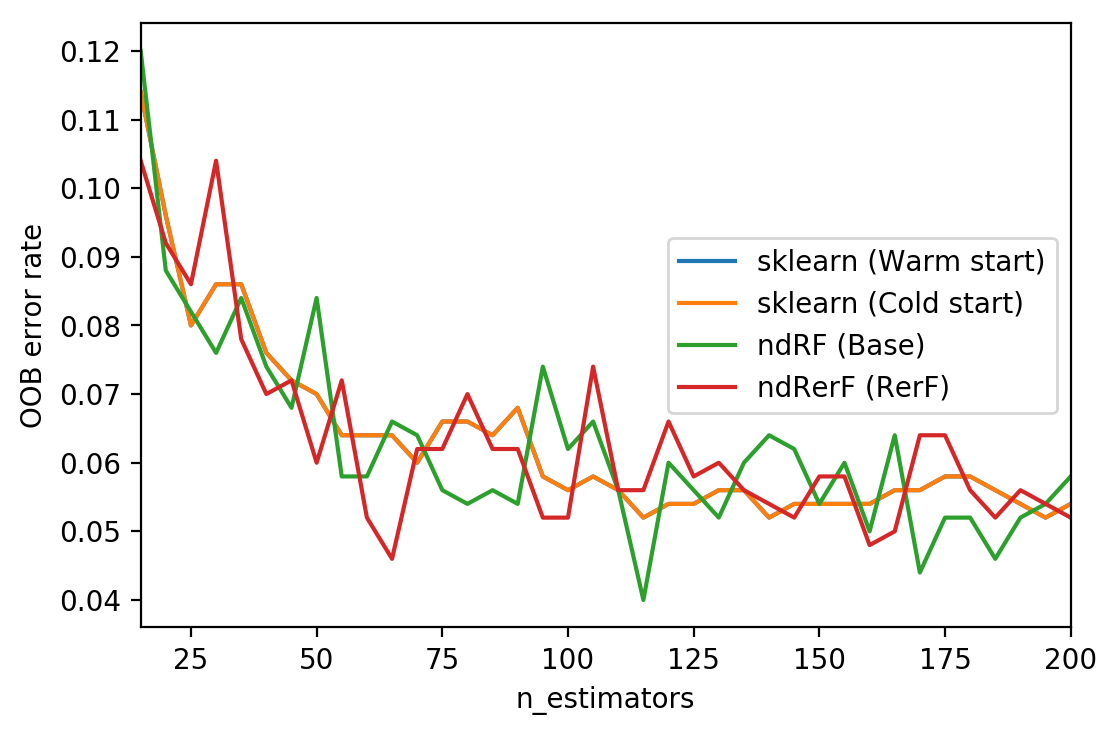

In [3]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="right")
plt.show()

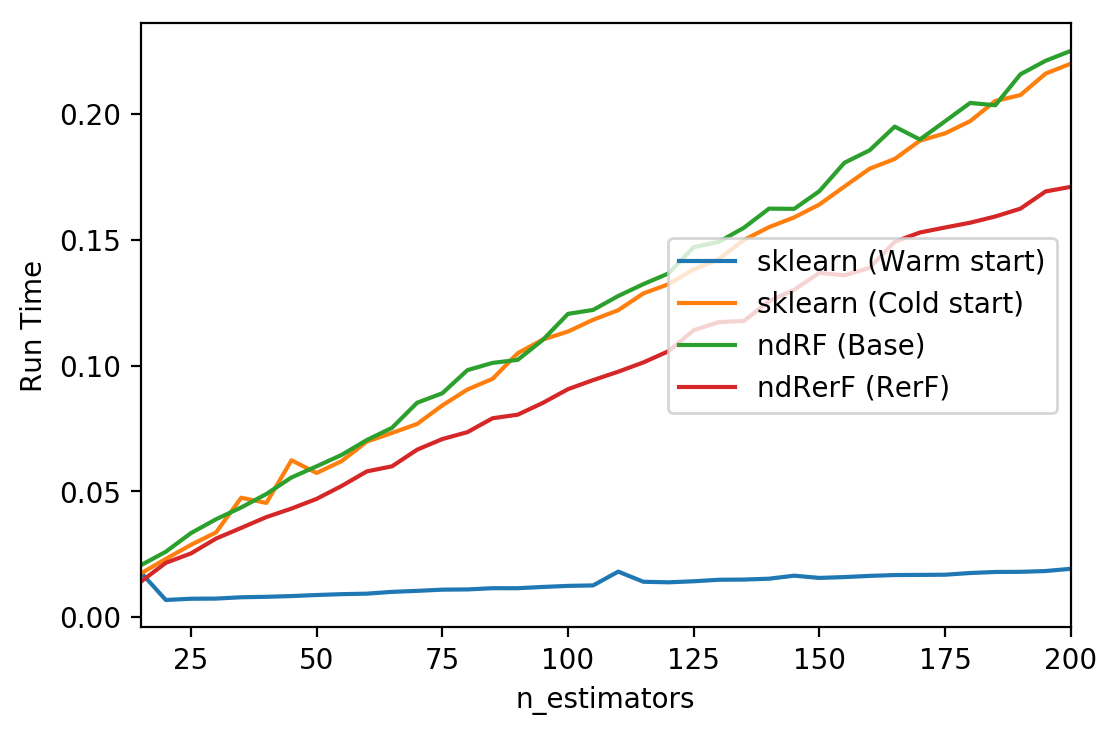

In [4]:
# generate test time plots
for label, rt in run_time.items():
    xs, ys = zip(*rt)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Run Time")
plt.legend(loc="right")
plt.show()